In [1]:
import pandas as pd
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel, model

SQLalchemy is not installed. No support for SQL output.


In [2]:
training_folder = '../../'

In [3]:
base = stepmodel.read_zip(training_folder + 'model/preparation/gtfs.zip')
base = base.change_epsg(epsg=32619, coordinates_unit='meter')
road = stepmodel.read_zip(training_folder + 'model/preparation/road.zip')

sm = base.copy()
sm.road_links = road.road_links
sm.road_nodes = road.road_nodes

zones: 100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


In [4]:
sm._add_type_prefixes()

AttributeError: 'StepModel' object has no attribute 'zones'

# Networkcaster
à faire sur un réseau propre, avant l'agrégation

In [ ]:
sm.integrity_fix_sequences()

dropped broken sequences: []


In [ ]:
sm.integrity_test_all(errors='raise', verbose=False)

50586it [00:03, 15208.24it/s]
50586it [00:12, 3971.87it/s]


In [ ]:
first_trips = set(sm.links.groupby(['route_id'])['trip_id'].min())
sm.links['direction_id'] = 0
sm.links.loc[sm.links['trip_id'].isin(first_trips), 'direction_id'] = 1
sm.links['trip_id'] = sm.links['route_id'] +'_' +(sm.links['direction_id'] + 1).astype(str)

## rail

In [ ]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(
    ['tram', 'subway', 'rail', 'brt', 'gondola', 'cable_car', 'express_bus']
)
]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|████████████████████████████████████████████████████████████| 2810/2810 [00:00<00:00, 103766.39it/s]


## road

In [ ]:
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [ ]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=20, 
    n_neighbors=10, 
    penalty_factor=1,
    replace_nodes=False
)

victoria_2: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:14<00:00,  2.15it/s]


## both road and rail

In [ ]:
both = road.copy()
both.links = pd.concat([road.links, rail.links]) 

In [ ]:
if not len(sm.links) == len(both.links):
    print('if not len(sm.links) == len(both.links): cuidado ')

In [ ]:
both.analysis_lines(line_columns='all')

# to_zip

In [ ]:
both.to_zip(
    training_folder + 'model/preparation/gtfs_networkcasted.zip',
    only_attributes=('links', 'nodes', 'epsg', 'coordinates_unit')
)  

jsons: 100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.79it/s]


<AxesSubplot:>

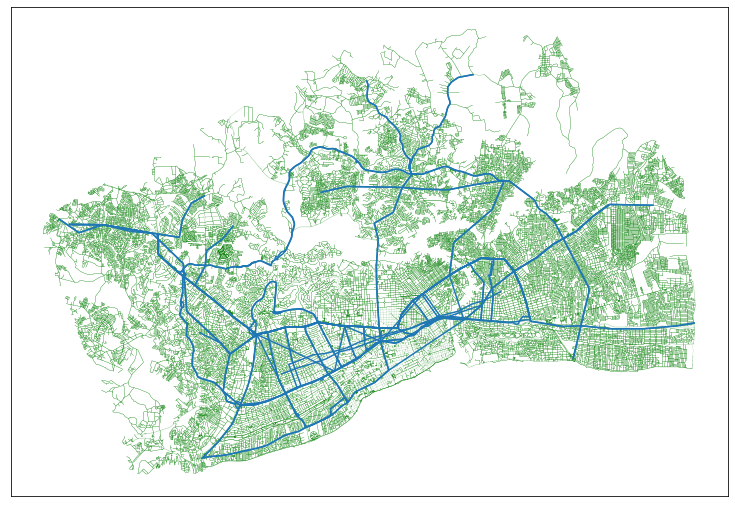

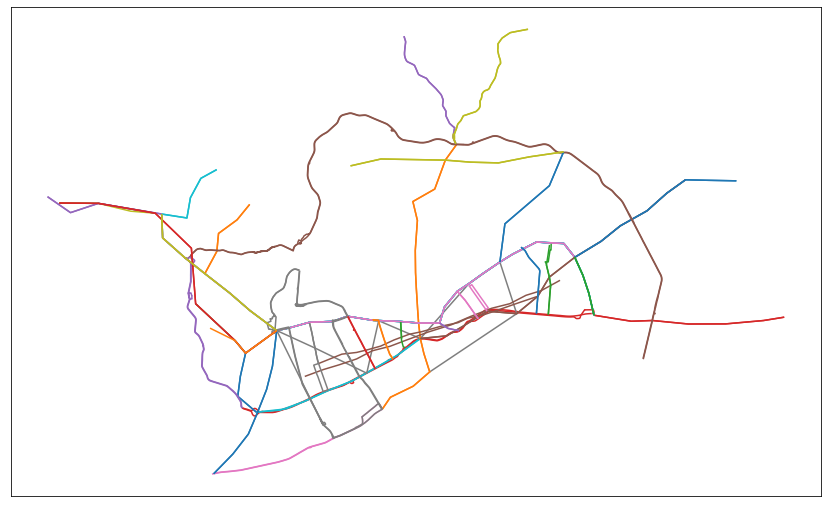

In [ ]:
%matplotlib inline
both.plot('links', ax=both.plot('road_links', color='green', figsize=[16, 9], linewidth=0.1))
both.plot('lines', figsize=[16, 9], column='route_color')

# networkcaster_monitoring

In [ ]:
from shapely.geometry import LineString

links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

# summary
(lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int)

Deprecated: replaced by analysis_lines


link_straight_length    204
straight_length         174
length                  218
dtype: int32

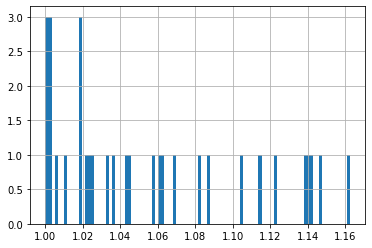

In [ ]:
%matplotlib inline
ax = lines['length_ratio'].hist(bins=100)

In [ ]:
lines.sort_values('length_ratio').tail()

,trip_id,route_id,direction_id,trip_headsign,trip_short_name,block_id,shape_id,service_id,route_long_name,route_short_name,route_type,route_color,link_straight_length,geometry,length,straight_length,length_ratio
18,sitp_nunez_1,sitp_nunez,0,first trip of the pattern,default,default,61572,Martes,sitp_nunez,sitp_nunez,bus,C00098,10364.827135,"LINESTRING (398799.224 2045831.306, 398786.834...",11800.253968,6378.950982,1.138490
23,sitp_prolongacion_27_2,sitp_prolongacion_27,1,first trip of the pattern,default,default,61581,Martes,sitp_prolongacion_27,sitp_prolongacion_27,bus,61ED48,6617.675975,"LINESTRING (394488.913 2046138.144, 394503.733...",7551.032348,6097.388951,1.141040
15,sitp_josefa_2,sitp_josefa,1,first trip of the pattern,default,default,58294,Martes,sitp_josefa,sitp_josefa,bus,AB9D6E,1169.076947,"LINESTRING (406153.938 2044278.350, 406236.832...",1335.675993,1148.576377,1.142505
10,sitp_churchill_1,sitp_churchill,0,first trip of the pattern,default,default,61570,Martes,sitp_churchill,sitp_churchill,bus,C179BF,8151.430147,"LINESTRING (402062.942 2040350.507, 402009.353...",9346.272271,6353.034864,1.146581
8,sitp_cdg_oeste_1,sitp_cdg_oeste,0,first trip of the pattern,default,default,61578,Martes,sitp_cdg_oeste,sitp_cdg_oeste,bus,749219,15343.992510,"LINESTRING (404973.624 2050791.773, 404959.053...",17835.802030,11570.841557,1.162396
